In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as ac
from scipy import special
import string
import re
import random
from tqdm import tqdm

from collections import Counter
from sklearn.metrics import accuracy_score

In [2]:
random.seed = 42
np.random.seed(42)

In [3]:
!head corpora/WarAndPeaceEng.txt

﻿The Project Gutenberg EBook of War and Peace, by Leo Tolstoy

This eBook is for the use of anyone anywhere at no cost and with almost
no restrictions whatsoever.  You may copy it, give it away or re-use it
under the terms of the Project Gutenberg License included with this
eBook or online at www.gutenberg.org


Title: War and Peace



In [4]:
text_ru_path = 'corpora/WarAndPeace.txt'
text_en_path = 'corpora/WarAndPeaceEng.txt'

In [5]:
def get_clean_text(path, regexp):
    with open(path, 'r') as file:
        text = file.read().lower()
    only_words = re.subn(pattern=regexp, repl=' ', string=text)[0]
    text = ' '.join(only_words.split())
    return text

In [6]:
text_ru = get_clean_text(text_ru_path, '[^а-я]')
text_en = get_clean_text(text_en_path, '[^a-z]')

In [7]:
ALPHABET_RU = 'абвгдежзийклмнопрстуфхцчшщъыьэюя '
ALPHABET_EN = 'abcdefghijklmnopqrstuvwxyz '

In [8]:
RU_TO_ID = {char : i for i, char in enumerate(ALPHABET_RU)}
EN_TO_ID = {char : i for i, char in enumerate(ALPHABET_EN)}

Для унификации работы алгоритма (и языков) перейдем к численному представлению символов алфавита

In [9]:
def apply_substitution(substitution, data):
    return np.array([substitution[char] for char in data])

In [10]:
def convert_to_chars(array, mapper):
    return ''.join([mapper[i] for i in array])

In [11]:
def report(open_data, key_for_decryption, cipher_data, alphabet=ALPHABET_EN):
    print('Encryption accuracy:', accuracy_score(apply_substitution(key_for_decryption, cipher_data), open_data))

    print('\nOriginal: ', convert_to_chars(open_data, alphabet))
    print('\nEncrypted:', convert_to_chars(apply_substitution(key_for_decryption, cipher_data), alphabet))

In [12]:
data_ru = apply_substitution(RU_TO_ID, text_ru)
data_en = apply_substitution(EN_TO_ID, text_en)

assert len(data_ru) == len(text_ru)
assert len(data_en) == len(text_en)

print('Размер корпуса русского языка:', len(data_ru))
print('Размер корпуса английского языка:', len(data_en))

Размер корпуса русского языка: 643122
Размер корпуса английского языка: 3108248


# Пункт 1

Реализуйте базовый частотный метод по Шерлоку Холмсу:
 - подсчитайте частоты букв по корпусам (пунктуацию и капитализацию можно просто опустить, а вот пробелы лучше оставить);
 - возьмите какие-нибудь тестовые тексты (нужно взять по меньшей мере 2-3 предложения, иначе вряд ли сработает), зашифруйте их посредством случайной перестановки символов;
 - расшифруйте их таким частотным методом.


In [13]:
distr_en = Counter(data_en)
key = np.random.permutation(len(ALPHABET_EN))

chunk_size = 300
open_text = data_en[:chunk_size]

cipher_text = apply_substitution(key, open_text)

distr_cipher_text = Counter(np.concatenate((np.arange(len(ALPHABET_EN)), cipher_text)))

inv_key = np.full(len(ALPHABET_EN), fill_value=-1)
for i, j in zip(distr_cipher_text.most_common(), distr_en.most_common()):
    inv_key[i[0]] = j[0]

    
report(open_text, inv_key, cipher_text)

Encryption accuracy: 0.4033333333333333

Original:  the project gutenberg ebook of war and peace by leo tolstoy this ebook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever you may copy it give it away or re use it under the terms of the project gutenberg license included with this ebook or online at www gutenber

Encrypted: are pntxela fmaeocenf ecttb ty dhn hog pehle cu wet atwsatu aris ecttb is ytn are mse ty houtoe houdrene ha ot ltsa hog diar hwvtsa ot nesanilaitos drhasteken utm vhu ltpu ia fike ia hdhu tn ne mse ia mogen are aenvs ty are pntxela fmaeocenf wileose iolwmgeg diar aris ecttb tn towioe ha ddd fmaeocen


Посмотрим на зависимость длины открытого текста от качества дешифровки:

In [14]:
def gram_accuracy(data, alphabet, size, key=key):
    distr = Counter(data)
    chunk_size = size
    open_text = data[:chunk_size]
    cipher_text = apply_substitution(key, open_text)
    distr_cipher_text = Counter(np.concatenate((np.arange(len(alphabet)), cipher_text)))

    inv_key = np.full(len(alphabet), fill_value=-1)
    for i, j in zip(distr_cipher_text.most_common(), distr.most_common()):
        inv_key[i[0]] = j[0]
    
    decrypted_text = apply_substitution(inv_key, cipher_text)
    return accuracy_score(decrypted_text, open_text)

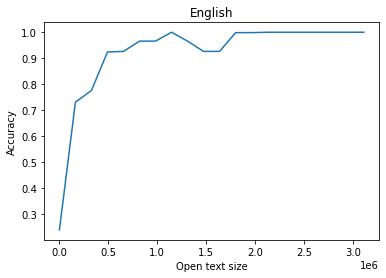

In [15]:
INIT_KEY_EN = np.random.permutation(len(ALPHABET_EN))

x_steps_en = np.linspace(100, len(data_en), num=20, dtype=int)
y_steps_en = [gram_accuracy(data_en, ALPHABET_EN, x, INIT_KEY_EN) for x in x_steps_en]
plt.plot(x_steps_en, y_steps_en)
plt.title('English')
plt.xlabel('Open text size')
plt.ylabel('Accuracy')
plt.show()

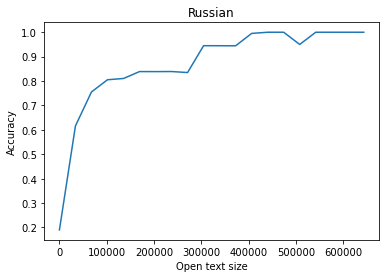

In [16]:
INIT_KEY_RU = np.random.permutation(len(ALPHABET_RU))


x_steps_ru = np.linspace(100, len(data_ru), num=20, dtype=int)
y_steps_ru = [gram_accuracy(data_ru, ALPHABET_RU, x, INIT_KEY_RU) for x in x_steps_ru]
plt.plot(x_steps_ru, y_steps_ru)
plt.title('Russian')
plt.xlabel('Open text size')
plt.ylabel('Accuracy')
plt.show()

Заметим, что в процентном соотношении числа символов в тексте от размера корпуса, английский язык немного быстрее растет в качестве (к 30% датасета точность=0.95, в русском же корпусе 30% текста соответствует примерно 0.85 точности)

# Пункт 2

## Биграммы

Аналогично считаем частоты биграмм для всего текста

In [17]:
def bigrams_accuracy(data, alphabet, size, key=key):
    bigrams = zip(data, data[1:])
    distr_bigrams = Counter(bigrams)
    
    chunk_size = size
    open_text = data[:chunk_size]
    cipher_text = apply_substitution(key, open_text)
        
    cipher_text_bigrams = zip(cipher_text,cipher_text[1:])
    distr_bigrams_cipher = Counter(cipher_text_bigrams)
    
    inv_key = np.full(len(alphabet), fill_value=-1)
    
    z = list(zip(distr_bigrams.most_common(), distr_bigrams_cipher.most_common()))
    for (o, _), (c, _) in z:
        o_start, o_end = o
        c_start, c_end = c
        
        if inv_key[c_start] == -1:
            inv_key[c_start] = o_start

        if inv_key[c_end] == -1:
            inv_key[c_end] = o_end
            
    
    decrypted_text = apply_substitution(inv_key, cipher_text)
    return accuracy_score(decrypted_text, open_text)

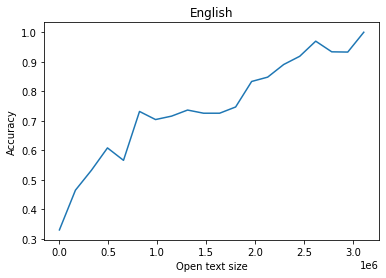

In [18]:
x_steps_bi_en = np.linspace(100, len(data_en), num=20, dtype=int)
y_steps_bi_en = [bigrams_accuracy(data_en, ALPHABET_EN, x, INIT_KEY_EN) for x in x_steps_bi_en]
plt.plot(x_steps_bi_en, y_steps_bi_en)

plt.title('English')
plt.xlabel('Open text size')
plt.ylabel('Accuracy')
plt.show()

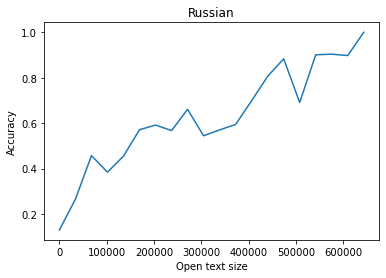

In [19]:
x_steps_bi_ru = np.linspace(100, len(data_ru), num=20, dtype=int)
y_steps_bi_ru = [bigrams_accuracy(data_ru, ALPHABET_RU, x, INIT_KEY_RU) for x in x_steps_bi_ru]
plt.plot(x_steps_bi_ru, y_steps_bi_ru)
plt.title('Russian')
plt.xlabel('Open text size')
plt.ylabel('Accuracy')
plt.show()

Сравним 1-граммы и 2-граммы:

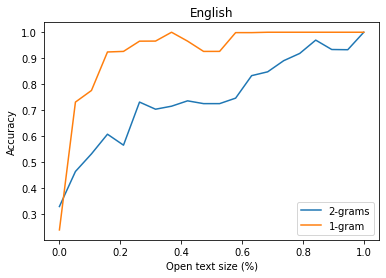

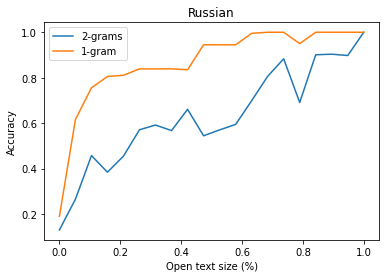

In [20]:
plt.plot(x_steps_bi_en / x_steps_bi_en.max(), y_steps_bi_en, label='2-grams')
plt.plot(x_steps_en / x_steps_en.max(), y_steps_en, label='1-gram')

plt.title('English')
plt.xlabel('Open text size (%)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(x_steps_bi_ru / x_steps_bi_ru.max(), y_steps_bi_ru, label='2-grams')
plt.plot(x_steps_ru / x_steps_ru.max(), y_steps_ru, label='1-gram')
plt.title('Russian')
plt.xlabel('Open text size (%)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Заметим, что качество ухудшилось на обоих языках (причем хуже на всех размерах подвыборки)

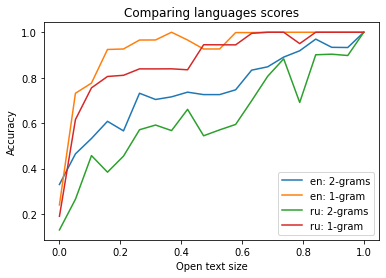

In [21]:
plt.plot(x_steps_bi_en / x_steps_bi_en.max(), y_steps_bi_en, label='en: 2-grams')
plt.plot(x_steps_en / x_steps_en.max(), y_steps_en, label='en: 1-gram')
plt.plot(x_steps_bi_ru / x_steps_bi_ru.max(), y_steps_bi_ru, label='ru: 2-grams')
plt.plot(x_steps_ru / x_steps_ru.max(), y_steps_ru, label='ru: 1-gram')
plt.xlabel('Open text size')
plt.title('Comparing languages scores')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

    Вывод по вступительной части:
    1. 1-граммы дают лучшее качество (чем биграммы)
    2. Английский алфавит расшифровывается лучше (возможно сказывается меньший алфавита + практически в 5 раз больше корпуса)

# Пункт 3

In [22]:
def get_bigrams(data):
    return zip(data, data[1:])

In [23]:
bigrams_matrix_ru = np.zeros(shape=(len(ALPHABET_RU), len(ALPHABET_RU)))
bigrams_matrix_en = np.zeros(shape=(len(ALPHABET_EN), len(ALPHABET_EN)))

In [24]:
for bigramm, val in Counter(get_bigrams(data_ru)).items():
    bigrams_matrix_ru[bigramm] = val

for bigramm, val in Counter(get_bigrams(data_en)).items():
    bigrams_matrix_en[bigramm] = val

In [25]:
import seaborn as sns

Посмотрим на распределение биграмм в языках:

In [26]:
plt.rcParams['figure.figsize'] = (10, 8)

<AxesSubplot:>

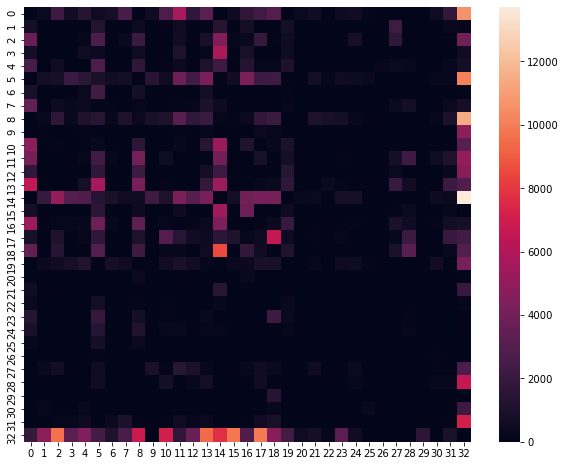

In [27]:
sns.heatmap(bigrams_matrix_ru, )

<AxesSubplot:>

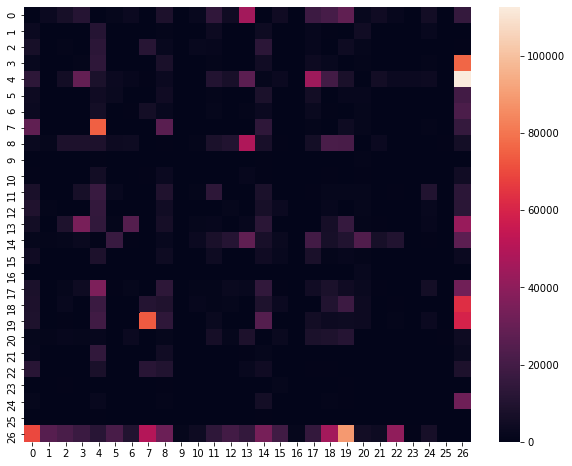

In [28]:
sns.heatmap(bigrams_matrix_en)

In [29]:
def log_likelihood(decrypted_data, n_grams_matrix):
    log_likelihood = 0
    for idx in get_bigrams(decrypted_data):
        p = n_grams_matrix[tuple(idx)]
        log_likelihood += np.log(p + 1e-5)
    return log_likelihood

In [30]:
print('Open text, LL:', log_likelihood(open_text, bigrams_matrix_en))
print('Cipher text, LL:', log_likelihood(cipher_text, bigrams_matrix_en))

Open text, LL: 2865.6811220943555
Cipher text, LL: 666.8053133552261


In [31]:
MAX_TRANSPOSITION = 10
N_ITERATIONS = 25000

In [32]:
def q_sample(substitution):
    s = np.copy(substitution)
    n_transposition = np.random.randint(1, MAX_TRANSPOSITION)
    for i in range(n_transposition):
        a = np.random.randint(len(substitution))
        b = np.random.randint(len(substitution))
        s[a], s[b] = s[b], s[a]
    return s

def metropolis_hastings_log_accept(l, l_new):
    if l_new > l:
        return True
    else:
        return np.random.rand() < np.exp((l_new - l))
    
def metropolis_hastings(
    func_log_likelihood, 
    iterations, 
    init_substitution, 
    cipher_text, 
    n_grams_matrix):
    
    #init stage
    s = np.copy(init_substitution)
    decrypted_data = apply_substitution(s, cipher_text)
    cur_l = func_log_likelihood(decrypted_data, n_grams_matrix)
    
    log_likelihood = []
    steps = []
    samples = [s]
    accept_bit = [1]
    
    for i in range(iterations):
        #generate new substitution
        new_substitution = q_sample(s)
        samples.append(new_substitution)

        #couning new lll
        decrypted_data = apply_substitution(new_substitution, cipher_text)
        new_l = func_log_likelihood(decrypted_data, n_grams_matrix)
        
        #check improvement
        if (metropolis_hastings_log_accept(cur_l, new_l)):
            s, cur_l = new_substitution, new_l
            accept_bit.append(1)
            log_likelihood.append(cur_l)
            steps.append(i)
        else:
            accept_bit.append(0)
    return np.array(steps), np.array(log_likelihood), np.array(samples), np.array(accept_bit)


def search_key(init_substitution, iterations, func_log_likelihood, cipher_text, n_grams_matrix):


    steps, lll, samples, accept_bit = metropolis_hastings(
        func_log_likelihood=func_log_likelihood, 
        iterations=iterations, 
        init_substitution=init_substitution, 
        cipher_text=cipher_text, 
        n_grams_matrix=n_grams_matrix
    )
    
    decrypt_key = samples[accept_bit == 1][np.argmax(lll)]
    cur_lll = log_likelihood(apply_substitution(decrypt_key, cipher_text), n_grams_matrix)
    return decrypt_key, cur_lll

In [33]:
decrypt_key, cur_lll = search_key(init_substitution = INIT_KEY_EN,
                                iterations=N_ITERATIONS,
                                  func_log_likelihood=log_likelihood,
                                  cipher_text=cipher_text,
                                  n_grams_matrix=bigrams_matrix_en)
print('Log likelihood:', cur_lll)

report(open_text, decrypt_key, cipher_text)

Log likelihood: 2765.62413823684
Encryption accuracy: 0.57

Original:  the project gutenberg ebook of war and peace by leo tolstoy this ebook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever you may copy it give it away or re use it under the terms of the project gutenberg license included with this ebook or online at www gutenber

Encrypted: ile btozedi hmienceth ecoov of pat ang beade cy ueo iousioy ilrs ecoov rs fot ile mse of anyone anyplete ai no dosi ang pril auwosi no tesitrdirons plaisoeket yom way doby ri hrke ri apay ot te mse ri mnget ile ietws of ile btozedi hmienceth urdense rndumgeg pril ilrs ecoov ot onurne ai ppp hmiencet


Возьмем несколько разных "точек старта":

In [34]:
def find_best_key_pipeline(alphabet_size, iterations, func_log_likelihood, cipher_text, n_grams_matrix):
    best_key = np.zeros(alphabet_size)
    best_likelihood = -1e10 
    for i in tqdm(range(20)):
        random_substitution = np.random.permutation(alphabet_size)
        decrypt_key, cur_lll = search_key(init_substitution = random_substitution,
                                        iterations=N_ITERATIONS,
                                      func_log_likelihood=log_likelihood,
                                      cipher_text=cipher_text,
                                      n_grams_matrix=n_grams_matrix)
        if cur_lll > best_likelihood:
            best_likelihood = cur_lll
            best_key = decrypt_key
            print(cur_lll)
    
    print('Best log likelihood:', cur_lll)

    return best_key

In [35]:
best_key = find_best_key_pipeline(len(ALPHABET_EN),
                                  N_ITERATIONS,
                                  log_likelihood,
                                  cipher_text,
                                  bigrams_matrix_en)
report(open_text, best_key, cipher_text)

  5%|▌         | 1/20 [00:17<05:37, 17.78s/it]

2760.236765667184


 10%|█         | 2/20 [00:35<05:19, 17.74s/it]

2888.376564566227


 25%|██▌       | 5/20 [01:28<04:25, 17.68s/it]

2892.0347085083854


100%|██████████| 20/20 [05:53<00:00, 17.68s/it]

Best log likelihood: 2876.5837761155076
Encryption accuracy: 0.9033333333333333

Original:  the project gutenberg ebook of war and peace by leo tolstoy this ebook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever you may copy it give it away or re use it under the terms of the project gutenberg license included with this ebook or online at www gutenber

Encrypted: the brovect mutenderm edook of war ang beace dy leo tolstoy this edook is for the use of anyone anywhere at no cost ang with alpost no restrictions whatsoezer you pay coby it mize it away or re use it unger the terps of the brovect mutenderm license inclugeg with this edook or online at www mutender


# Пункт 4

In [36]:
unknown_text = 'დჳჵჂႨშႼႨშჂხჂჲდႨსႹႭჾႣჵისႼჰႨჂჵჂႨႲႹႧჲჂႨსႹႭჾႣჵისႼჰႨჲდႩჳჲႨჇႨႠჲႹქႹႨჳႹႹჱჶდსჂႽႨႩႹჲႹႭႼჰႨჵდქႩႹႨႲႭႹႧჂჲႣჲიႨჳႩႹႭდდႨშჳდქႹႨშႼႨშჳდႨჳხდჵႣჵჂႨႲႭႣშჂჵისႹႨჂႨႲႹჵჇႧჂჲდႨჾႣႩჳჂჾႣჵისႼჰႨჱႣჵჵႨეႣႨႲႹჳჵდხსდდႨႧდჲშდႭჲႹდႨეႣხႣსჂდႨႩჇႭჳႣႨႾႹჲႽႨႩႹსდႧსႹႨႽႨსჂႧდქႹႨსდႨႹჱდჶႣნ'


In [37]:
ALPHABET_UNK = set(unknown_text)
UNK_TO_ID = {c: i for i, c in enumerate(ALPHABET_UNK)}

In [38]:
data_unknown = apply_substitution(UNK_TO_ID, unknown_text)

In [39]:
best_key_unk = find_best_key_pipeline(len(ALPHABET_RU),
                                  N_ITERATIONS,
                                  log_likelihood,
                                  data_unknown,
                                  bigrams_matrix_ru)

  5%|▌         | 1/20 [00:13<04:25, 14.00s/it]

1734.7950812915035


 10%|█         | 2/20 [00:27<04:11, 13.97s/it]

1781.0745973745318


 75%|███████▌  | 15/20 [03:28<01:09, 13.89s/it]

1799.4216489425255


100%|██████████| 20/20 [04:37<00:00, 13.90s/it]

Best log likelihood: 1762.9045663367676


In [40]:
decrypted_unk_data = apply_substitution(best_key_unk, data_unknown)
print(convert_to_chars(decrypted_unk_data, ALPHABET_RU))

если вы видите норжальный или помти норжальный текст у этого сообчения который легко промитать скорее всего вы все сделали правильно и полумите жаксижальный балл ша последнее метвертое шадание курса хотя конемно я нимего не обечаз


# Вывод

1. 1-граммы дают лучшее качество (чем биграммы)
2. Английский алфавит расшифровывается лучше (возможно сказывается меньший алфавита + практически в 5 раз больше корпуса)
3. Семплирование "решает" (смогли достичь на выборке размера 300 такое же качества, как в случае "голых" 1-2-грамм на выборке размера ~ 500к слов)
4. Добавление случайной инициализации повысило качество (ушли от локального минимума насколько это возможно)